In [1]:
from PIL import Image
import requests
import os, glob
import pandas as pd
import numpy as np
import re
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/home/lu.kev/.conda/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import importlib
# Make changes to esd_diffusers.py file here
from eta_diffusion import FineTunedModel, StableDiffuser

In [ ]:
import numpy as np

class ExperimentImageSet:
    def __init__(self, image_array: np.ndarray, num_attack_images: int):
        self.stable_diffusion_base_image: np.ndarray = image_array[0]
        self.eta_0_image: np.ndarray = image_array[1]
        self.attack_images: np.ndarray = image_array[2:2 + num_attack_images]
        self.interference_images: np.ndarray = image_array[2 + num_attack_images:]

    def return_full_image_array(self) -> np.ndarray:
        image_array = []
        len_attacks = len(self.attack_images)
        image_array.append(self.stable_diffusion_base_image)
        image_array.append(self.eta_0_image)
        image_array.extend(self.attack_images)  # Half of attack images
        image_array.extend(self.interference_images)  # Add all interference images
        return np.array(image_array)
    
    def return_attacked_images(self, max_columns: int) -> np.ndarray:
        image_array = []
        len_attacks = len(self.attack_images)
        
        # Check if the total number of images exceeds max_columns
        if len_attacks + 2 > max_columns:
            image_array.append(self.stable_diffusion_base_image)
            image_array.append(self.eta_0_image)
            image_array.extend(self.attack_images[len_attacks // 2:])  # Half of attack images
            image_array.append(self.stable_diffusion_base_image)
            image_array.append(self.eta_0_image)
            image_array.extend(self.attack_images[: len_attacks // 2])  # Half of attack images
        else:
            image_array.append(self.stable_diffusion_base_image)
            image_array.append(self.eta_0_image)
            image_array.extend(self.attack_images)  # Half of attack images
            image_array.extend(self.interference_images)  # Add all interference images
        
        return np.array(image_array)

In [5]:
import torch
import numpy as np
torch.cuda.empty_cache()
variance_scales = [1.0]
etas=[0.5, 0.7, 0.9, 1.0]
prompts = [
    "A mermaid gazing up at the stars in the style of Kelly McKernan"
]

# seeds = [1440, 2440, 3125, 9385, 2347, 1033, 1234, 5198, 5138, 1341]
seeds = [3778]
killian_prompt = "A surreal, dreamlike landscape featuring a strange, floating island or structure, in the style of Kilian Eng"
killian_seed = 2058
thomas_prompt = "A tranquil, peaceful painting of a quiet countryside road or winding path, with warm, inviting light and delicate, intricate details that capture the essence of Thomas Kinkade's style"
thomas_seed = 1755
# etas = [0.0]
model_path = 'models/esd-kellymckernan_from_kellymckernan-xattn_1-epochs_200.pt'
state_dict = torch.load(model_path)
diffuser = StableDiffuser(scheduler='DDIM').to('cuda')
finetuner = FineTunedModel(diffuser, train_method='xattn')
finetuner.load_state_dict(state_dict)

total_images = []
ct = 0
for prompt in prompts:
    for seed in seeds:
        eta_image, images_steps, decoded_latents, latents, noise_preds, output_steps = diffuser(prompt, n_steps=50, generator=torch.manual_seed(seed), eta=0.0, variance_scale=0.0)
        total_images.append(eta_image)
        with finetuner:
            eta_image, images_steps, decoded_latents, latents, noise_preds, output_steps = diffuser(prompt, n_steps=50, generator=torch.manual_seed(seed), eta=0.0, variance_scale = 0.0)
            total_images.append(eta_image)
            for eta in etas:
                for variance_scale in variance_scales:
                    eta_image, images_steps, decoded_latents, latents, noise_preds, output_steps = diffuser(prompt, n_steps=50, generator=torch.manual_seed(seed), eta=eta, variance_scale = variance_scale)
                    total_images.append(eta_image)
            eta_image, images_steps, decoded_latents, latents, noise_preds, output_steps = diffuser(killian_prompt, n_steps=50, generator=torch.manual_seed(killian_seed), eta=0.0, variance_scale = 0.0)
            total_images.append(eta_image)
            eta_image, images_steps, decoded_latents, latents, noise_preds, output_steps = diffuser(thomas_prompt, n_steps=50, generator=torch.manual_seed(thomas_seed), eta=0.0, variance_scale = 0.0)
            total_images.append(eta_image)
        ct += 1 + len(etas) + 2
        print("diffusion-count", ct)
total_images = np.array(total_images)

fixed_images = []
for image in total_images:
    fixed_images.append(image[0][49])
# Assuming fixed_images is already defined as an array
fixed_images = np.array(fixed_images)

print("image grid shape", fixed_images.shape)

code changed


/home/lu.kev/.conda/envs/pytorch_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


0.18215


/home/lu.kev/.conda/envs/pytorch_env/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'skip_prk_steps': True} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
/home/lu.kev/eta_diffusion.py:229: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, self.unet.in_channels, img_size // 8, img_size // 8),
100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


latents_steps shape:  (50, 1, 3, 512, 512)


100%|██████████| 50/50 [00:07<00:00,  7.12it/s]


latents_steps shape:  (50, 1, 3, 512, 512)


100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


latents_steps shape:  (50, 1, 3, 512, 512)


100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


latents_steps shape:  (50, 1, 3, 512, 512)


100%|██████████| 50/50 [00:07<00:00,  7.02it/s]


latents_steps shape:  (50, 1, 3, 512, 512)


100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


latents_steps shape:  (50, 1, 3, 512, 512)


100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


latents_steps shape:  (50, 1, 3, 512, 512)


100%|██████████| 50/50 [00:07<00:00,  7.01it/s]


latents_steps shape:  (50, 1, 3, 512, 512)
diffusion-count 7
image grid shape (8, 512, 512, 3)


In [6]:
caption = "A mermaid gazing up at the stars in the style of Kelly McKernan"
inputs = processor(text=[caption], images=fixed_images, return_tensors="pt", padding=True)
outputs = model(**inputs)
clip_score = outputs.logits_per_image[0][0].detach().cpu() # this is the image-text similarity score
print(clip_score)
print(outputs)

tensor(34.8399)
CLIPOutput(loss=None, logits_per_image=tensor([[34.8399],
        [30.5166],
        [34.7140],
        [32.4830],
        [32.6361],
        [31.8536],
        [20.6261],
        [11.2576]], grad_fn=<TBackward0>), logits_per_text=tensor([[34.8399, 30.5166, 34.7140, 32.4830, 32.6361, 31.8536, 20.6261, 11.2576]],
       grad_fn=<MulBackward0>), text_embeds=tensor([[-3.8882e-03, -1.3740e-02, -8.0752e-03,  2.2486e-02,  7.3722e-03,
          2.4989e-03, -3.6498e-02, -3.0868e-02, -2.5784e-02,  5.4807e-03,
          3.6440e-02, -3.4797e-02,  7.0417e-02, -2.4887e-02, -4.3962e-02,
          5.7092e-02, -9.5261e-02, -1.1620e-02,  3.3874e-02,  4.1568e-02,
          2.2006e-02,  1.0187e-02, -1.2085e-02,  2.2759e-02,  4.3796e-02,
         -4.0535e-03, -5.7039e-02,  2.5359e-03, -6.5983e-04, -4.5162e-02,
          1.5605e-02, -9.7888e-03, -5.8005e-03, -3.3728e-02, -3.1574e-02,
          4.7478e-02,  9.1417e-04,  2.1574e-02,  7.6057e-03,  5.8422e-03,
          3.2877e-02, -1.2256e-02,

In [7]:
print(outputs.logits_per_image)

tensor([[34.8399],
        [30.5166],
        [34.7140],
        [32.4830],
        [32.6361],
        [31.8536],
        [20.6261],
        [11.2576]], grad_fn=<TBackward0>)


In [13]:
int_list = [np.round(float(x.item()), 2) for x in outputs.logits_per_image]

print(int_list)

[34.84, 30.52, 34.71, 32.48, 32.64, 31.85, 20.63, 11.26]


In [8]:
print(outputs.logits_per_image[0])

tensor([34.8399], grad_fn=<SelectBackward0>)


In [18]:
import matplotlib.pyplot as plt

def show_image_grid(img_files, subtitles=None, num_rows=3, num_cols=4, fig_size=(15, 10)):
    # Create a grid to display the images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size)

    # Plot each image in the grid row-wise
    for i, ax in enumerate(axes.flatten()):
        img_index = i  # row-major order
        if img_index < len(img_files):
            img = img_files[img_index]
            ax.imshow(img)
            # If subtitles are provided, set them as the title
            if subtitles and img_index < len(subtitles):
                ax.set_title(subtitles[img_index], fontsize=18)
        ax.axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()

# Example usage
# img_files = [image1, image2, image3, ...]  # Replace with actual images
# subtitles = ["Subtitle 1", "Subtitle 2", "Subtitle 3", ...]  # Replace with actual subtitles
# show_image_grid(img_files, subtitles=subtitles)


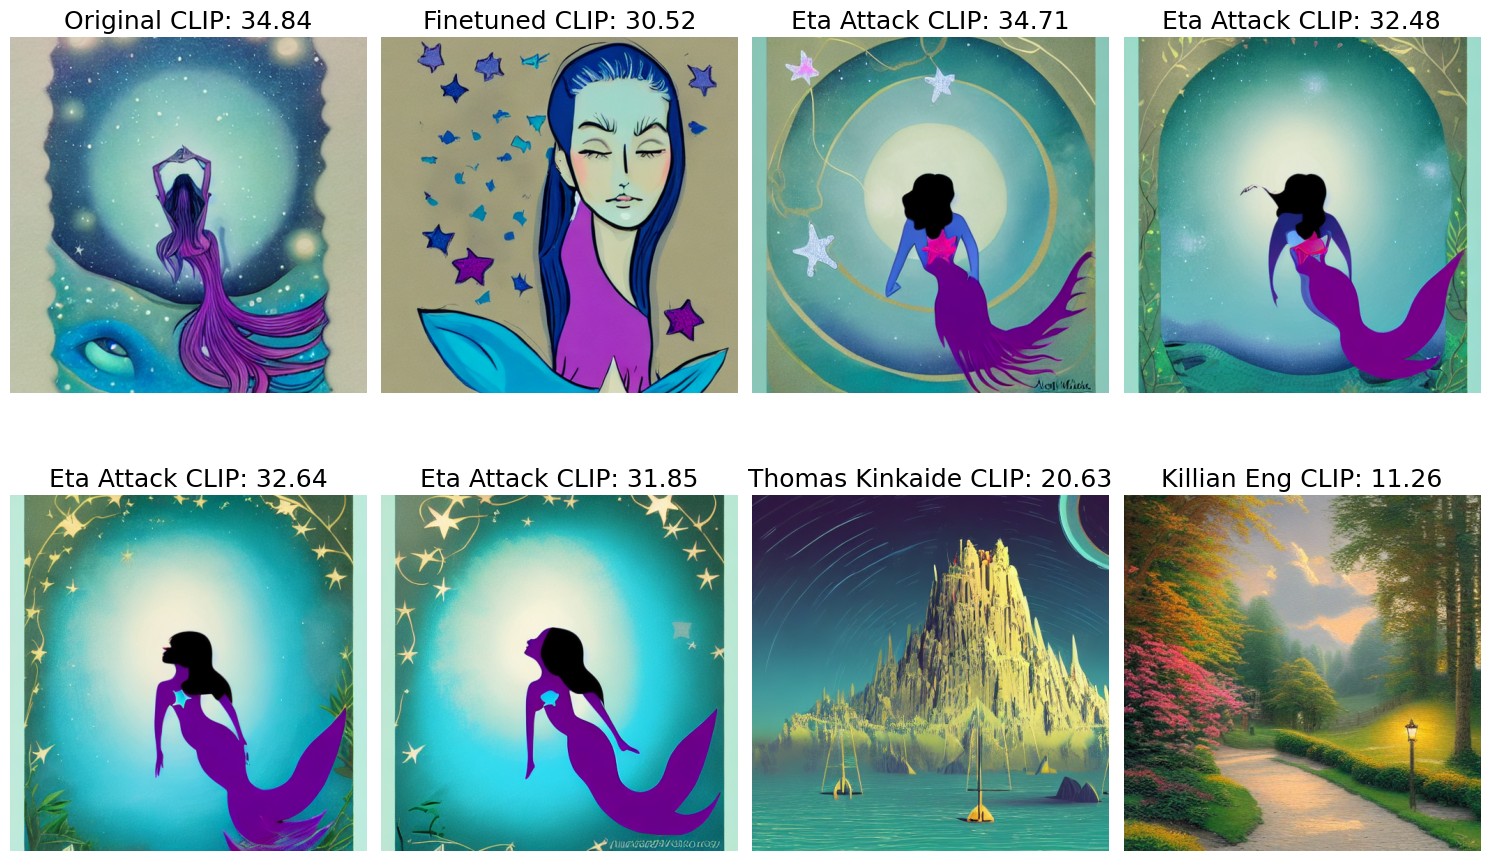

In [26]:
subtitles = ['Original', 'Finetuned', 'Eta Attack', 'Eta Attack', 'Eta Attack', 'Eta Attack', 'Thomas Kinkaide', 'Killian Eng']

for i in range(len(subtitles)):
    subtitles[i] = subtitles[i] + " CLIP: " + str(int_list[i])
show_image_grid(fixed_images, subtitles=subtitles, num_rows=2, num_cols=4)

In [25]:
experiment_set = ExperimentImageSet(fixed_images, 4)

In [30]:
experiment_set.return_full_image_array(5).shape

(12, 512, 512, 3)

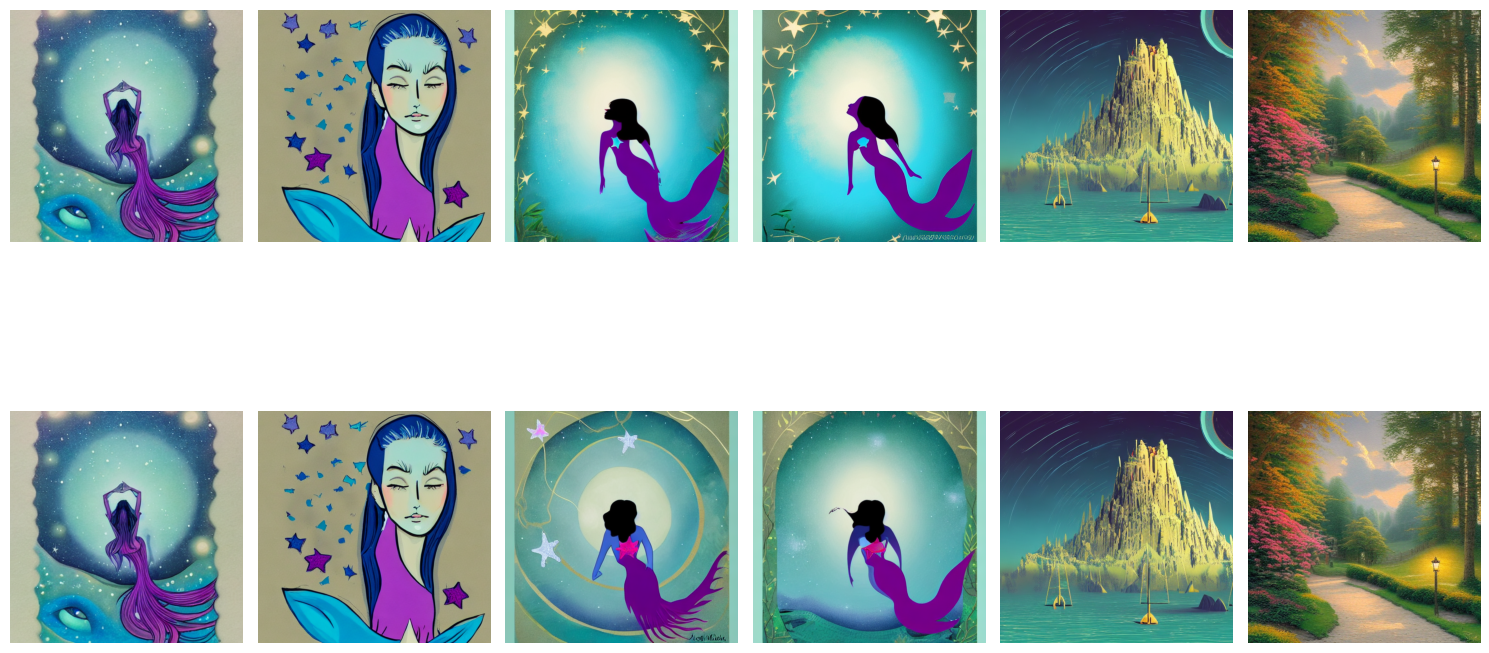

In [32]:
show_image_grid(experiment_set.return_full_image_array(5), num_rows=2, num_cols=6)

In [34]:
def plot_experiment_grid(experiment_set: ExperimentImageSet, max_columns: int, row_labels: list, column_labels: list):
    # Get the images from the ExperimentImageSet
    image_array = experiment_set.return_full_image_array(max_columns=max_columns)
    print(len(image_array))
    num_rows = len(row_labels)
    num_cols = len(column_labels)

    # Create a figure with subplots for each image
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    # Plot each image in its respective position and label it
    for i in range(num_rows):
        for j in range(num_cols):
            img = image_array[j % len(image_array)]  # Adjust index if necessary

            # Plot the image in the grid
            axes[i, j].imshow(img)
            axes[i, j].axis('off')  # Remove axis for cleaner look

            # Set column labels
            if i == 0:
                axes[i, j].set_title(column_labels[j], fontsize=12)

        # Set row labels
        axes[i, 0].text(-0.5, 0.5, row_labels[i], va='center', ha='center', fontsize=12, transform=axes[i, 0].transAxes)

    # Adjust layout to fit the grid properly
    plt.tight_layout()
    plt.show()

8


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

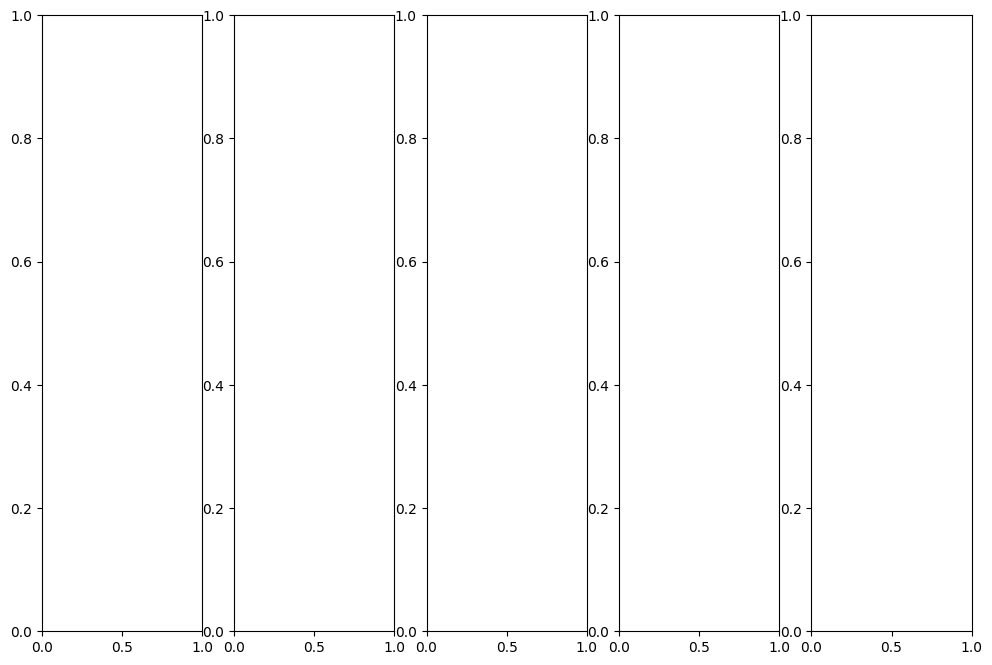

In [36]:
# Labels for rows and columns (customize based on your experiment)
row_labels = ['1\nAlex Alemany']
column_labels = ['Original SD', 'Our Method', '', 'Killian', 'Thomas']




In [12]:
print(clip_score)

tensor(7.5180)


In [13]:
import matplotlib.pyplot as plt

def show_image_grid(img_files, num_rows=3, num_cols=4, fig_size=(15, 10)):
    # Create a grid to display the images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fig_size)

    # Plot each image in the grid row-wise
    for i, ax in enumerate(axes.flatten()):
        img_index = i  # row-major order
        if img_index < len(img_files):
            img = img_files[img_index]
            ax.imshow(img)
        ax.axis('off')  # Turn off axis labels

    plt.tight_layout()
    plt.show()

# Example usage
# img_files = [image1, image2, image3, ...]  # Replace with actual images
# show_image_grid(img_files)